# Testing new utility function for MPO

Data imports.

In [10]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1
import warnings
warnings.filterwarnings('ignore') 

import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library_sorted.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

import torch
import pyarrow.parquet as pq
table = pq.read_table('../../dgym-data/sizes.parquet')[0]
sizes = torch.tensor(table.to_numpy())

Instantiate designer.

In [4]:
from dgym.envs.designer import Designer, Generator

designer = Designer(
    Generator(building_blocks, fingerprints, sizes),
    reactions,
    cache = True
)

Instantiate Oracles.

In [5]:
from dgym.envs.utility import ClassicUtilityFunction

docking_utility_function = ClassicUtilityFunction(
    ideal=(8, 11),
    acceptable=(7.5, float('inf'))
)

log_P_utility_function = ClassicUtilityFunction(
    ideal=(1, 3),
    acceptable=(-0.5, 4.5)
)

log_S_utility_function = ClassicUtilityFunction(
    ideal=(-2, 1),
    acceptable=(-4, 0)
)

In [52]:
Z

array([[-30.25      , -30.05124477, -29.85901949, ..., -29.85901949,
        -30.05124477, -30.25      ],
       [-29.64720437, -29.44844914, -29.25622385, ..., -29.25622385,
        -29.44844914, -29.64720437],
       [-29.05093868, -28.85218345, -28.65995817, ..., -28.65995817,
        -28.85218345, -29.05093868],
       ...,
       [ -2.125     ,  -1.92624477,  -1.73401949, ...,  -1.73401949,
         -1.92624477,  -2.125     ],
       [ -2.125     ,  -1.92624477,  -1.73401949, ...,  -1.73401949,
         -1.92624477,  -2.125     ],
       [ -2.125     ,  -1.92624477,  -1.73401949, ...,  -1.73401949,
         -1.92624477,  -2.125     ]])

Text(0.5, 1.0, 'Utility function for multi-objective')

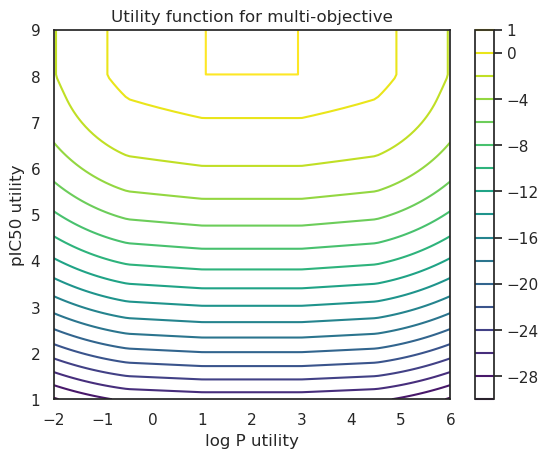

In [94]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='white')
log_P_scores = np.linspace(-2, 6, 100)
docking_scores = np.linspace(1, 9, 100)

log_P_utility = log_P_utility_function(log_P_scores)
docking_utility = docking_utility_function(docking_scores)

plt.xlabel('log P utility')
plt.ylabel('pIC50 utility')

X, Y = np.meshgrid(log_P_scores, docking_scores)
Z = np.mean([
    log_P_utility_function(X.ravel()), docking_utility_function(Y.ravel())], axis=0)
Z = Z.reshape(100, 100)

contour = plt.contour(
    X, Y, Z, levels=[*list(range(-30, 2, 2)), 0.99999], cmap="viridis")

bar = plt.colorbar(contour)
bar.set_ticks([*bar.get_ticks(), 1.])
plt.title('Utility function for multi-objective')

<Axes: >

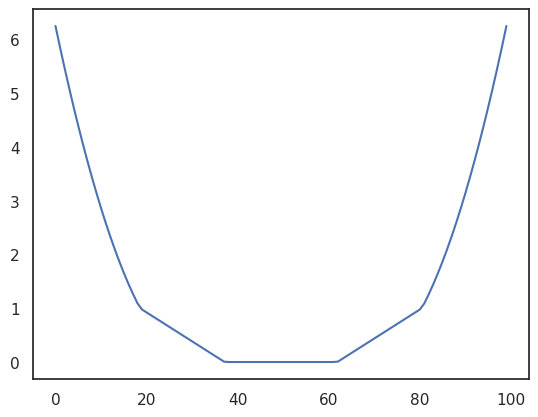

In [11]:
sns.lineplot(log_P_utility)

## Pareto-sorting / non-dominated sorting

In [590]:
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

log_S_scores = np.random.uniform(-6, 2, 500)
log_P_scores = np.random.uniform(-4, 8, 500)
docking_scores = np.random.uniform(4, 9.5, 500)

scores = np.array([
    log_S_scores,
    log_P_scores,
    docking_scores
]).T

# transform scores
utilities = [
    log_S_utility_function(log_S_scores),
    log_P_utility_function(log_P_scores),
    docking_utility_function(docking_scores)
]

utilities = np.vstack(utilities).T

# perform sort
nds, nds_ranks = NonDominatedSorting().do(utilities, return_rank=True, only_non_dominated_front=False)
penalty_sums = np.sum(utilities, axis=1)
penalty_prods = np.prod(utilities, axis=1)
fused_ranks = np.lexsort([penalty_sums, nds_ranks]) # prioritizes last column

Plotting fronts.

Text(0.5, 1.0, 'Non-dominated sorting fronts with a multi-objective function')

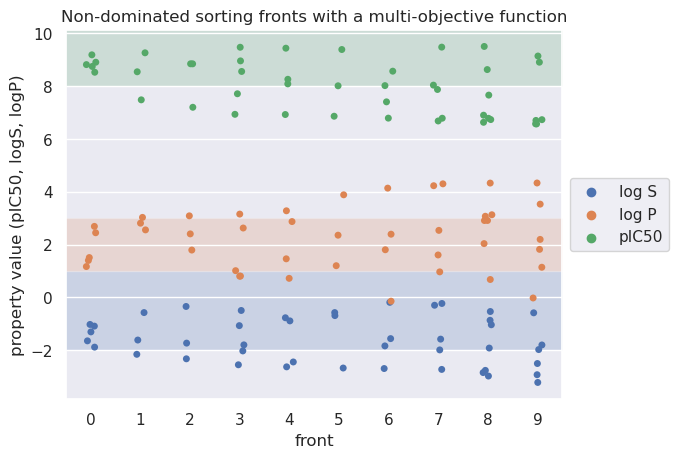

In [591]:
num_fronts = 10
utility_fns = ['log S', 'log P', 'pIC50']

records = []
records_merged = []
for idx, front in enumerate(nds[:num_fronts]):
    for jdx in front:
        score = scores[jdx]
        for adx, value in enumerate(score):
            records_merged.append({
                'property value (pIC50, logS, logP)': value,
                'assay': utility_fns[adx],
                'front': idx,
            })

        record = {name: value for (name, value) in zip(utility_fns, score)}
        record.update({'front': idx})
        records.append(record)

df = pd.DataFrame(records)
df_merged = pd.DataFrame(records_merged)

plt.fill_betweenx(log_S_utility_function.ideal, -1, num_fronts, alpha=0.2, zorder=-10)
plt.fill_betweenx(log_P_utility_function.ideal, -1, num_fronts, alpha=0.2, zorder=-10)
plt.fill_betweenx(docking_utility_function.ideal, -1, num_fronts, alpha=0.2, zorder=-10)

g = sns.stripplot(
    df_merged,
    x='front',
    y='property value (pIC50, logS, logP)',
    hue='assay',
)

# Put the legend out of the figure
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# g.set_ybound(-6, 10)

plt.title('Non-dominated sorting fronts with a multi-objective function')

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


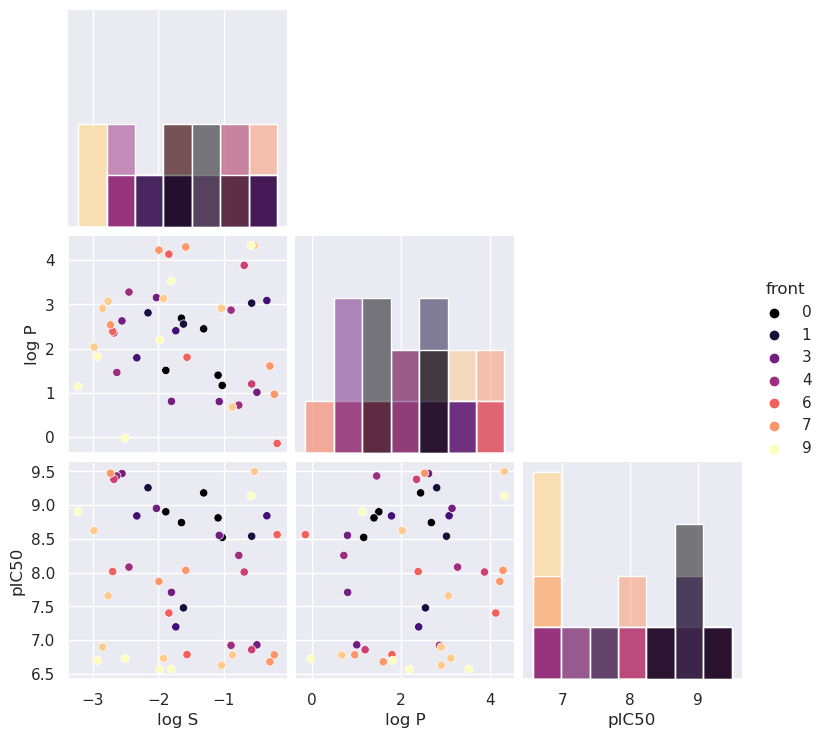

In [592]:
sns.pairplot(df, hue='front', palette='magma', corner=True, diag_kind='hist')

Text(0.5, 0, 'Rank')

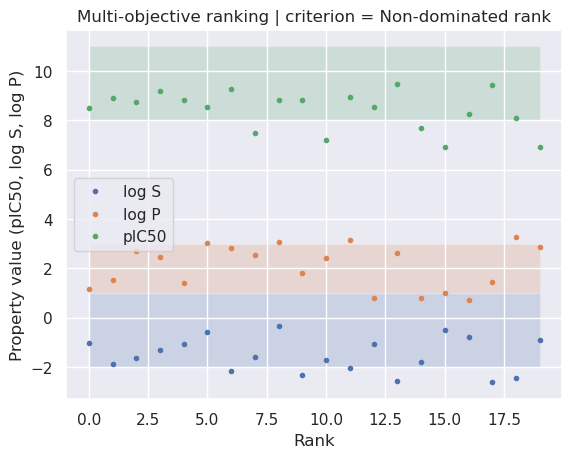

In [594]:
sns.set()

best_scores = scores[fused_ranks[:20]].reshape(-1, 3)

plt.plot(best_scores, '.')
plt.legend(['log S', 'log P', 'pIC50'])

plt.fill_betweenx(log_S_utility_function.ideal, 0, len(best_scores) - 1, alpha=0.2, zorder=-10)
plt.fill_betweenx(log_P_utility_function.ideal, 0, len(best_scores) - 1, alpha=0.2, zorder=-10)
plt.fill_betweenx(docking_utility_function.ideal, 0, len(best_scores) - 1, alpha=0.2, zorder=-10)

plt.title('Multi-objective ranking | criterion = Non-dominated rank')
plt.ylabel('Property value (pIC50, log S, log P)')
plt.xlabel('Rank')